In [1]:
%matplotlib inline
# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# import modules and plot setting
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

from mangatools import linmix
from mangatools import maps, datacube, utils
from mangatools.fitmaps import FitMaps

today = datetime.date.today().isoformat()

# set the display properties
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# customize the warning message
import warnings
warnings.filterwarnings("ignore") # default or ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data relese: MPL-8, configure: mangatools/config.py
Global SAS directory is /Volumes/Lacie2


# Outflow (deprecated)

alpha: +3.567±0.065, beta: +0.145±0.060, sig^2: 0.064


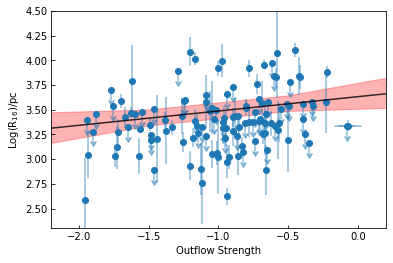

In [303]:
# Outflow strength and the size of ENLR
LO3data = Table.read('data/LO3-2019-06-25.dat', format="ascii")
Rdata = Table.read('data/R_fsb-(10)-2019-06-19.dat', format='ascii')
mcmc_fitting = Table.read('data/mcmc.txt', format='ascii')
is_converge = (mcmc_fitting['is_converge'] >= 1)
LO3 = LO3data['LO3_redcorr']
LO3_err = LO3data['LO3_redcorr_err_up']

R = Rdata['logR_fsb2_orig']
R_err = Rdata['logR_fsb2_orig_err']
R_uplims = (Rdata['is_limit'] == 1)
R[R_uplims] = Rdata['logR_fsb2'][R_uplims]

#s = R > 0
# plot the outflow signature
outflow_strength = LO3data['outflow_strength']
outflow_strength_err = LO3data['outflow_strength_err']
is_valid = (LO3 > 38) & (LO3 < 45) & (R > 2.0) & (R < 5.0) & (LO3_err < 1)
ss = (outflow_strength > 0.01) & is_valid
fig, ax = plt.subplots(1,1, figsize=(6, 4))

#ax.semilogx(outflow_strength, R, 'o')
#ax.errorbar(outflow_strength, R, xerr=outflow_strength_err, yerr=R_err, ls='None', marker=None, alpha=0.5)
#ax.set_xlabel('outflow strength')
#ax.set_ylabel('log(R)')

if 1: # fitting with linmix
    xfit = np.log10(outflow_strength[ss])
    xfit_err = outflow_strength_err[ss]/np.log(10)/xfit
    yfit = R[ss]
    yfit_err = R_err[ss]

    ax.plot(xfit, yfit, 'o', color='C0')
    ax.set_xlabel('Outflow Strength')
    #ax.set_ylabel(r'log($R_{16}$[pc])')
    ax.set_ylabel(r"Log(R$_{16}$)/pc")
    ax.errorbar(xfit, yfit, xerr=xfit_err, yerr=yfit_err, uplims=R_uplims[ss], ls='None', marker=None, alpha=0.5, color='C0')
    
    lm = linmix.LinMix(xfit, yfit, xfit_err, yfit_err, K=2)
    lm.run_mcmc(silent=True)
    
    #for i in range(0, len(lm.chain), 25):
    #    xs = np.arange(38,46)
    #    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    #    ax.plot(xs, ys, color='r', alpha=0.02)
    curves = []
    xs = np.arange(-3.5, 2.2)
    for i in range(0, len(lm.chain)):
        curves.append(lm.chain[i]['alpha'] + xs * lm.chain[i]['beta'] + lm.chain[i]['sigsqr'])

    # Plot 95% confidence interval
    lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
    #ax.fill_between(xs, lo, hi, color='red', alpha=0.2)
    ax.fill_between(xs, lo, hi, color='red', alpha=0.3)
    alpha, alpha_err = np.mean(lm.chain['alpha']), np.std(lm.chain['alpha'])
    beta, beta_err = np.mean(lm.chain['beta']), np.std(lm.chain['beta'])
    sigsqr = np.mean(lm.chain['sigsqr'])
    print(r"alpha: {:+.3f}±{:.3f}, beta: {:+.3f}±{:.3f}, sig^2: {:.3f}".format(
            alpha, alpha_err, beta, beta_err, sigsqr))
    ax.plot(xs, alpha + xs * beta + sigsqr, 'k-', alpha=0.8)
    ax.set_xlim(-2.2, 0.2)
    ax.set_ylim(2.3, 4.5)
    
if False: # do fitting
    xfit = outflow_strength
    xfit_err = outflow_strength_err
    yfit = R
    yfit_err = R_err
    
    p = lts_linefit(xfit, yfit, xfit_err, yfit_err, clip=3, epsy=True, corr=True, frac=None, 
                    pivot=0, plot=False, text=False)

    # show fitting results
    rms = np.std(p.ab[0] + p.ab[1]*xfit[p.mask] - yfit[p.mask], ddof=2)
    par = np.append(p.ab, p.sig_int)
    sig_par = np.append(p.ab_err, p.sig_int_err)

    xmin, xmax = np.min(xfit), np.max(xfit)
    dx = xmax - xmin
    xlimits = np.array([xmin - dx, xmax + dx])
    y_res = par[0] + par[1]*xlimits
    ax.plot(xlimits, y_res, '-k')
    ax.plot(xlimits, y_res + rms, '--r', alpha=0.3)
    ax.plot(xlimits, y_res - rms, '--r', alpha=0.3)
    #ax.set_title(r"$y = (0.307 \pm 0.021) x - (9.09 \pm 0.86)$", fontsize=fs)
    #ax.text(41., 2.7, "Spearman r=0.78, p=1e-19 \n Pearson r=0.84, p=1e-25", 
    #        fontsize=fs)
fig.savefig('./results/outflow.pdf', bbox_inches='tight')

In [304]:
# calculate the correlation of the two variable
xx = xfit.data
yy = yfit.data

np.mean((xx - np.mean(xx))*(yy - np.mean(yy))) / (np.std(xx)*np.std(yy))

0.24994104659821717

In [51]:
from scipy.stats import mstats

mstats.ttest_rel(xx, yy)

Ttest_relResult(statistic=-98.80393466154254, pvalue=9.06411067923439e-120)

# IR luminosity

In [25]:
# generate the target file to request data from http://wise2.ipac.caltech.edu/docs/release/allwise/
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
with open('data/agn_coords.txt', 'w') as f:
    f.write("|   ra          |    dec      |\n")
    f.write("|   double      |    double   |\n")
    f.write("|   deg         |    deg      |\n")
    f.write("|   null        |    null     |\n")
    for g in targets:
        f.write("  {:.8f}    {:.8f}\n".format(g['ra'], g['dec']))
f.close()

In [4]:
tt = Table.read('data/irsa_catalog_search_results.tbl.txt', format='ipac')
tt[:2]

cntr_01,dist_x,pang_x,ra_01,dec_01,designation,ra,dec,sigra,sigdec,sigradec,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,pmra,sigpmra,pmdec,sigpmdec,cc_flags,ext_flg,var_flg,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m
,arcsec,deg,deg,deg,,deg,deg,arcsec,arcsec,arcsec,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,,,,,maspyr,maspyr,maspyr,maspyr,,,,,,,,,,,,,
int64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,str4,int64,str4,str4,str4,int64,int64,int64,int64,int64,int64,int64,int64
1,0.044455,-112.673053,205.04476857,26.84104106,J134010.74+265027.7,205.0447558,26.8410363,0.0541,0.0555,-0.0058,13.944,0.026,41.2,1.829,13.756,0.036,30.1,1.005,11.152,0.132,8.2,0.9379,8.33,--,1.8,0.7771,1,0,0.0,0.0,0.0,0.0,138,101,-2,109,0000,0,00nn,AABU,0011,30,30,30,30,4,15,0,15
2,0.03975,-89.948108,319.19309865,11.04374079,J211646.34+110237.4,319.1930874,11.0437408,0.0365,0.0348,0.0068,12.274,0.022,48.6,4.603,11.544,0.021,51.9,1.432,8.805,0.029,37.0,1.046,6.172,0.048,22.4,0.9475,1,0,0.0,0.0,0.0,0.0,54,42,-213,42,0000,1,1100,AAAA,0100,35,35,31,31,17,17,17,17


In [9]:
def fixdata(arr):
    fixed_arr = []
    for i in arr:
        try:
            tmp = np.float(i)
        except:
            tmp = -9999.0
        if np.isnan(tmp):
            tmp = -9999.0
        fixed_arr.append(tmp)
    return np.array(fixed_arr)


In [ ]:
# Comparing L[OIII] and L_IR

this_Ldata = Table.read('data/LO3-2019-06-25.dat', format="ascii")
this_Rdata = Table.read('data/R_fsb-(10)-2019-06-19.dat', format='ascii')
L_IR = []
L_IR_err = []
#IR_wave = [3.4, 4.6, 12, 22]
wise_f0 = np.array([309.54, 171.787, 31.674, 8.363])
target_wave = 8 #in um
for i, gal in enumerate(this_Rdata[:]):
    m = maps.Maps(gal['plateifu'])
    
    wise_pho = fixdata(tt[i]['w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']) 
    wise_pho_err = fixdata(tt[i]['w1sigmpro', 'w2sigmpro', 'w3sigmpro', 'w4sigmpro'])
    wise_flux = wise_f0 * 10**(-wise_pho/2.5)
    wise_flux_err = wise_f0 * 10**(-wise_pho/2.5) * np.log(10) / 2.5 * wise_pho_err
    
    f = (wise_flux[2] - wise_flux[1]) / 7.4 * (target_wave - 4.6) + wise_flux[1]
    f_err = np.sqrt((1/7.4*(target_wave-4.6) * wise_flux_err[2])**2 + ((1-1/7.4*(8-4.6))*wise_flux_err[1])**2)
        
    L = np.log10(f*1e-23/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2) * 3e10/(1e-4 * target_wave))
    #L_err = np.log10(f*1e-23/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2) * 3e10/12e-4)
    L_err = f_err/np.log(10)/f
    #print(wise_flux)
    #print(wise_flux_err)
    #print(f, f_err)
    #print(L, L_err)
    L_IR.append(L.value)
    L_IR_err.append(L_err)
np.savetxt('data/L_IR.txt', np.array(L_IR))

sig_int:     0.0000      0.5790
Computing sig_int
sig_int:     0.0000      0.5790
sig_int:     0.5128     -0.6051
sig_int:     0.2507     -0.1002
sig_int:     0.2137      0.0161
sig_int:     0.2189     -0.0007
sig_int:     0.2187     -0.0000
sig_int:     0.2185      0.0004
Computing sig_int error
sig_int:     0.2187      0.1162
sig_int:     0.5128     -0.4888
sig_int:     0.2752     -0.0542
sig_int:     0.2572     -0.0031
sig_int:     0.2561      0.0000
sig_int:     0.2563     -0.0004
Repeat at best fitting solution
sig_int:     0.2187     -0.0000
################# Values and formal errors ################
 intercept:  2.1 +/- 2.4
     slope:  0.904 +/- 0.057
   scatter:  0.219 +/- 0.037
Observed rms scatter: 0.437 
Spearman r=0.76 and p=9e-30
Pearson r=0.74 and p=7.9e-28
##########################################################
seconds 16.95


(38.0, 43.5)

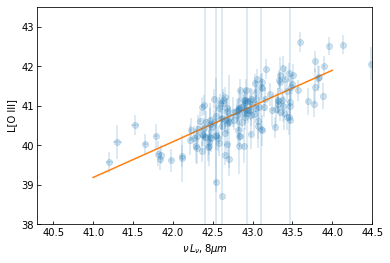

In [11]:
from ltsfit.lts_linefit import lts_linefit

xfit = np.array(L_IR)
xfit_err = np.array(L_IR_err)

this_L = this_Ldata['LO3_redcorr'].data
this_L_err = 0.5 * (this_Ldata['LO3_redcorr_err_up'].data + this_Ldata['LO3_redcorr_err_low'].data)
yfit = this_L
yfit_err = this_L_err

ss = (xfit < 1e4) & (xfit > 1e-4) & (yfit > 0) & (yfit < 1e4) & (yfit_err < 1e4)

p = lts_linefit(xfit[ss], yfit[ss], xfit_err[ss], yfit_err[ss], clip=3, epsy=True, corr=True, frac=None, 
                    pivot=0, plot=False, text=False)
xlimits = np.linspace(41., 44, 100)
y_res = p.ab[0] + p.ab[1]*xlimits
plt.errorbar(xfit, yfit, xerr=xfit_err, yerr=yfit_err, ls='None', marker='o', alpha=0.2)
plt.plot(xlimits, y_res)

plt.xlabel(r'$\nu\, L_\nu, 8\mu m$')
plt.ylabel('L[O III]')

plt.xlim(40.3, 44.5)
plt.ylim(38.0, 43.5)

Only our data: alpha: -12.582±1.906, beta: +0.369±0.044, sig^2: 0.050
All the data: alpha: -12.038±1.275, beta: +0.357±0.030, sig^2: 0.048


(2.3, 4.7)

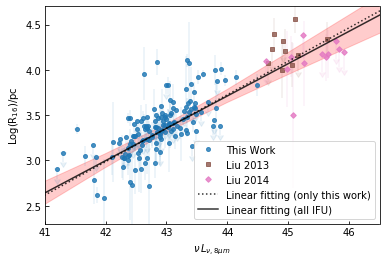

In [12]:
# L_IR and R_ENLR relation

import numpy as np
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from ltsfit.lts_linefit import lts_linefit
from mangatools import linmix

# preset for plot
fs = 16
lw = 2
ms = 4
pa = 0.8 # point alpha
ea = 0.1 #errorbar alpha

fig, ax = plt.subplots(1,1, figsize=(6, 4))
#ax.tick_params(axis='both', which='major', labelsize=fs)
#ax.tick_params(axis='both', which='minor', labelsize=fs-1)

X_all = [] #include all the data points
X_all_err = []
Y_all = []
Y_all_err = []
Y_delta = []

# default error, use for fitting
x_err_default = 0.2*np.log(10) # 20% error
y_err_default = 0.2*np.log(10) # 20% error


if True: #read our data
    #this_Ldata = Table.read('data/LO3-2019-06-25.dat', format="ascii")
    this_Rdata = Table.read('data/R_fsb-(10)-2019-06-19.dat', format='ascii')
    
    #this_L = this_Ldata['LO3_redcorr'].data
    #this_L_err = 0.5 * (this_Ldata['LO3_redcorr_err_up'].data + this_Ldata['LO3_redcorr_err_low'].data)
    this_L = np.array(L_IR)
    this_L_err = np.array(L_IR_err)
    
    this_r = this_Rdata['logR_fsb2_orig'].data
    this_r_err = this_Rdata['logR_fsb2_orig_err'].data

    this_islimit = this_Rdata['is_limit'].data == 1
    this_r[this_islimit] = this_Rdata['logR_fsb1'].data[this_islimit]

    is_valid = (this_L > 38) & (this_L < 45) & (this_r > 2.0) & (this_r < 5.0) & (this_L_err < 2) & (this_r_err < 1) #& ~this_islimit
    this_L = this_L[is_valid]
    this_L_err = this_L_err[is_valid]
    this_r = this_r[is_valid]
    this_r_err = this_r_err[is_valid]
    this_islimit = this_islimit[is_valid]
    
    X_all.append(this_L)
    X_all_err.append(this_L_err)
    Y_all.append(this_r)
    Y_all_err.append(this_r_err)
    Y_delta.append(~this_islimit)
    
    color = 'C0'
    marker = 'o'
    ax.plot(this_L, this_r, marker=marker, alpha=pa, label='This Work', 
            color=color, lw=lw, ms=ms, linestyle='None')
    plt.errorbar(this_L, this_r, xerr=this_L_err, uplims=this_islimit,
                 yerr=this_r_err, ls='None', label=None, alpha=ea, color=color)
    
if True: #read the data from Liu2013
    liu2013 = Table.read('data/Liu2013.txt', format='ascii')
    liu2013_corr = Table.read('data/liu2013_R_fsb-10-2019-06-25.dat', format='ascii')
    liu13_L5um = liu2013['vLv5um'].data
    liu13_L12um = liu2013['vLv12um'].data
    liu13_L = (liu13_L12um - liu13_L5um)/(12. - 4.6) * (8 - 4.6) + liu13_L5um # vLv8um
    liu13_L_err = np.full_like(liu13_L, 0.01)
    liu13_r = liu2013_corr['logR_fsb2_orig'].data
    liu13_r_err = liu2013_corr['logR_fsb2_orig_err'].data + 0.2/np.log(10)
    #liu13_islimit = np.full(liu13_r.shape, False)
    liu13_islimit = liu2013_corr['is_limit'].data == 1
    liu13_islimit = np.array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=bool) | liu13_islimit
    liu13_r[liu13_islimit] = liu2013_corr['logR_fsb1'].data[liu13_islimit]
    # only use the first 10 targets
    liu13_L = liu13_L[:10]
    liu13_L_err = liu13_L_err[:10]
    liu13_r = liu13_r[:10]
    liu13_r_err = liu13_r_err[:10]
    liu13_islimit = liu13_islimit[:10]
    
    X_all.append(liu13_L)
    X_all_err.append(np.full_like(liu13_L, x_err_default))
    Y_all.append(liu13_r)
    Y_all_err.append(liu13_r_err)
    Y_delta.append(~liu13_islimit)
    
    color = 'C5'
    marker = 's'
    ax.plot(liu13_L, liu13_r, marker=marker, alpha=pa, label='Liu 2013', 
            color=color, lw=lw, ms=ms, linestyle='None')
    plt.errorbar(liu13_L, liu13_r, yerr=liu13_r_err, xerr=liu13_L_err,
                 ls='None', label=None, alpha=ea, color=color, uplims=liu13_islimit)
    
if True: #read the data from Liu2014
    liu2014 = Table.read('data/Liu2014.txt', format='ascii')
    liu2014_corr = Table.read('data/liu2014_R_fsb-10-2019-06-25.dat', format='ascii')
    liu14_L = liu2014['vLv8um'].data
    liu14_L_err = np.full_like(liu14_L, 0.01)

    liu14_r = liu2014_corr['logR_fsb2_orig'].data
    #liu14_valid = (liu14_r > 0)
    liu14_r_err = liu2014_corr['logR_fsb2_orig_err'].data + 0.2/np.log(10)
    liu14_islimit = liu2014_corr['is_limit'].data == 1
    liu14_islimit = np.array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=bool) | liu14_islimit
    liu14_r[liu14_islimit] = liu2014_corr['logR_fsb1'].data[liu14_islimit]
    liu14_r_err[liu14_islimit] = 0.2
    
    X_all.append(liu14_L)
    X_all_err.append(np.full_like(liu14_L, x_err_default))
    Y_all.append(liu14_r)
    Y_all_err.append(liu14_r_err)
    Y_delta.append(~liu14_islimit)
    
    color = 'C6'
    marker = 'D'
    ax.plot(liu14_L, liu14_r, marker=marker, alpha=pa, label='Liu 2014', 
            color=color, lw=lw, ms=ms, linestyle='None')
    plt.errorbar(liu14_L, liu14_r, yerr=liu14_r_err, xerr=liu14_L_err,
                 ls='None', label=None, alpha=ea, color=color, uplims=liu14_islimit)


if True: #only fit our data
    xfit = this_L
    xfit_err = this_L_err
    yfit = this_r
    yfit_err = this_r_err
    ydelta = ~this_islimit

    lm = linmix.LinMix(xfit, yfit, xfit_err, yfit_err, delta=ydelta, K=2)
    lm.run_mcmc(silent=True)
    xs = np.arange(38,48)
    curves = []
    for i in range(0, len(lm.chain)):
        curves.append(lm.chain[i]['alpha'] + xs * lm.chain[i]['beta'] + lm.chain[i]['sigsqr'])

    # Plot 95% confidence interval
    alpha, alpha_err = np.mean(lm.chain['alpha']), np.std(lm.chain['alpha'])
    beta, beta_err = np.mean(lm.chain['beta']), np.std(lm.chain['beta'])
    sigsqr = np.mean(lm.chain['sigsqr'])
    print(r"Only our data: alpha: {:+.3f}±{:.3f}, beta: {:+.3f}±{:.3f}, sig^2: {:.3f}".format(
            alpha, alpha_err, beta, beta_err, sigsqr))
    ax.plot(xs, alpha + xs * beta + sigsqr, 'k:', alpha=0.8, label='Linear fitting (only this work)')
    
if True:
    xfit = np.concatenate(X_all)
    xfit_err = np.concatenate(X_all_err)
    yfit = np.concatenate(Y_all)
    yfit_err = np.concatenate(Y_all_err)
    ydelta = np.concatenate(Y_delta)

    lm = linmix.LinMix(xfit, yfit, xfit_err, yfit_err, delta=ydelta, K=2)
    lm.run_mcmc(silent=True)
    
    #for i in range(0, len(lm.chain), 25):
    #    xs = np.arange(38,46)
    #    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    #    ax.plot(xs, ys, color='r', alpha=0.02)
    curves = []
    xs = np.arange(38,48)
    for i in range(0, len(lm.chain)):
        curves.append(lm.chain[i]['alpha'] + xs * lm.chain[i]['beta'] + lm.chain[i]['sigsqr'])

    # Plot 95% confidence interval
    lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
    #lo, hi = np.percentile(curves, (17, 83), axis=0)
    ax.fill_between(xs, lo, hi, color='red', alpha=0.2)
    #ax.fill_between(xs, lo, hi, color='mistyrose', alpha=0.2)
    alpha, alpha_err = np.mean(lm.chain['alpha']), np.std(lm.chain['alpha'])
    beta, beta_err = np.mean(lm.chain['beta']), np.std(lm.chain['beta'])
    sigsqr = np.mean(lm.chain['sigsqr'])
    print(r"All the data: alpha: {:+.3f}±{:.3f}, beta: {:+.3f}±{:.3f}, sig^2: {:.3f}".format(
            alpha, alpha_err, beta, beta_err, sigsqr))
    ax.plot(xs, alpha + xs * beta + sigsqr, 'k-', alpha=0.8, label='Linear fitting (all IFU)')

plt.xlabel(r'$\nu\, L_{\nu, 8\mu m}$')
#ax.set_xlabel(r"${\rm Log(L[O\,III])}$", fontsize=fs)
ax.set_ylabel(r"Log(R$_{16}$)/pc")
ax.legend(loc='lower right')

plt.xlim(41, 46.5)
plt.ylim(2.3, 4.7)

#plt.savefig('./results/LIR-R.pdf', bbox_inches='tight')

In [274]:
liu13_L

array([44.89108108, 44.76189189, 44.66297297, 44.94324324, 45.11324324,
       44.91162162, 44.73027027, 45.63243243, 45.06216216, 45.16648649])

In [ ]:
nsa_catalog = Table.read('/Volumes/Lacie2/other/nsa_v1_0_1.fits')

In [95]:
select = (nsa_catalog['NSAID'] == m.drp['nsa_nsaid'])

In [ ]:
# Generate the photometry from GALEX and SDSS and WISE

from mangatools.maps import Maps
import pathlib

wise_wave = [3.4, 4.6, 12, 22]
wise_f0 = np.array([309.54, 171.787, 31.674, 8.363])

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

#i_base = 1
#targets = targets[i_base: i_base+1]

if True:
    for i, target in enumerate(targets[:]):
        #i = i + i_base
        pathlib.Path('./cjh_photometry/{}'.format(i)).mkdir(parents=True, exist_ok=True)

        f = open('cjh_photometry/{0}/{0}.txt'.format(i), 'w+')
        f.write("# id redshift FUV FUV_err NUV NUV_err u_prime u_prime_err g_prime g_prime_err r_prime r_prime_err i_prime i_prime_err z_prime z_prime_err WISE1 WISE1_err WISE2 WISE2_err WISE3 WISE3_err WISE4 WISE4_err\n")
        
        plateifu = target['plateifu']
        print(i, plateifu)
        m = Maps(plateifu)
        select = (nsa_catalog['NSAID'] == m.drp['nsa_nsaid'])
        sdss_flux = nsa_catalog['ELPETRO_FLUX'][select][0] * 1e-3
        sdss_flux_err = np.sqrt(1/nsa_catalog['ELPETRO_FLUX_IVAR'][select][0]) * 1e-3
        
        wise_pho = fixdata(tt[i]['w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']) 
        wise_pho_err = fixdata(tt[i]['w1sigmpro', 'w2sigmpro', 'w3sigmpro', 'w4sigmpro'])
        wise_flux = wise_f0 * 10**(-wise_pho/2.5) * 1e3
        wise_flux_err = wise_f0 * 10**(-wise_pho/2.5) * np.log(10) / 2.5 * wise_pho_err  * 1e3
        
        #print(sdss_flux)
        #print(sdss_flux_err)
        #print(wise_flux)
        #print(wise_flux_err)
        f.write("{} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n".format(i, m.z, *np.array(list(zip(sdss_flux, sdss_flux_err))).flatten(), *np.array(list(zip(wise_flux, wise_flux_err))).flatten()))
        f.close()

# Jets

In [ ]:
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

flux_tot = []
flux_tot_err = []

for i, target in enumerate(targets[:]):
    res1 = Table.read('/Volumes/DATA/cjh_photometry/{}/final/results.fits'.format(i))
    res2 = Table.read('/Volumes/DATA/cjh_photometry/{}/agn_final/results.fits'.format(i))
    if res1['best.reduced_chi_square'] > res2['best.reduced_chi_square']:
        res = res2
    else:
        res = res1
    flux, flux_err = res['bayes.agn.luminosity', 'bayes.agn.luminosity_err'][0]
    flux_tot.append(flux)
    flux_tot_err.append(flux_err)
L_tot = np.log10(np.array(flux_tot) * 1e7)
L_tot_err = np.array(flux_tot_err) * 1e7 / (np.array(flux_tot) * 1e7) / np.log(10)   

## 4400\AA luminosity

In [175]:
tab = Table.read('/Volumes/DATA/cjh_photometry/1/final/results.fits')
tab[:2]

id,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.agn.therm_luminosity,bayes.agn.therm_luminosity_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.B_B90,best.attenuation.E_BVs.stellar.old,best.attenuation.E_BVs.stellar.young,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.ebvs_old_factor,best.attenuation.powerlaw_slope,best.attenuation.stellar.old,best.attenuation.stellar.young,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.FUV,best.NUV,best.u_prime,best.g_prime,best.r_prime,best.i_prime,best.z_prime,best.WISE1,best.WISE2,best.WISE3,best.WISE4
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.3191315455363322e+37,9.383739770747507e+35,1.07884355031997e+37,9.914000571779584e+35,0.43254644340797727,0.026281145459230344,19.423740769032403,1.9423740769032403,2.308018485708164e+36,-0.25,0.45,4.0,1.3777290242479215e+37,140.0,20.1,150.0,4.352532580271556e+34,3.0,1.1425746430968335e+37,1.2643985457797113,0.25,0.25,2.569132881987268,1.0153041650353054,1.0,0.0,8.858381823272307e+36,5.1064193701334386e+36,1.0,217.5,35.0,2.8,0.02,1.3964801193405744e+37,9.545859813558333e+37,1.12,5.0,4520.0,1.0,0.0,33966950326.301613,2.945311645506657,3.032549276338252,2.953123108662302,20.0,1235.0,2472.3075853847904,1.0,2.548401977838699e+37,1.4448391667445247e+36,2.635112648331017e+34,1.4184880402612143e+36,1.8177538391116462e+37,7.306481387270526e+36,14573891640.876314,14572138689.156374,1752951.7199397215,19393058676.583176,19365280406.05873,27778270.524444275,0.02,4.359807394334932e+53,6.337882522998811e+51,4.296428569104944e+53,10.0,12693.611506079042,1.1266935008912497e+25,0.0806967,0.023233963892856712,0.03291728125986794,0.0733698331366696,0.25323704921470286,0.4741869290748326,0.6921463926144482,0.9376061407024942,3.3165817082820435,4.3743768039667765,10.595982287314676,25.568622849140276


In [2]:
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

Lv_4400 = []

for idx, plateifu in enumerate(targets['plateifu'][:]):
    #plateifu = '7495-1902'
    print(idx, plateifu)
    m = maps.Maps(plateifu)
    dc = datacube.Datacube(plateifu)
    sp = dc.stack2(m.mask, vmap=m.vfield())
    wave_wind = (sp.wave/(1+sp.z) < 4460) & (sp.wave/(1+sp.z) > 4430)
    wave_select = sp.wave[wave_wind]
    flux = 1e-17 / u.angstrom * np.sum(dc.flux[wave_wind])/(wave_select[-1] - wave_select[0]) * 4400**2 *u.angstrom**2 / const.c.to(u.angstrom/u.s)
    Lv = flux / u.cm**2 * 4*np.pi*(m.d**2).to(u.cm**2)
    Lv_4400.append(Lv.value)
    
Lv_4400 = np.array(Lv_4400)
np.savetxt('data/Lv.txt', Lv_4400)

0 7495-1902
1 7815-6104
2 7991-6104
3 7991-3702
4 8132-6101
5 8247-6101
6 8137-3702
7 8141-1901
8 8143-6101
9 8256-12704
10 8249-3704
11 8319-12705
12 8341-12704
13 8439-6104
14 8452-1901
15 8483-12703
16 8482-12704
17 8549-12701
18 8465-12704
26 8606-12701
27 8314-3704
28 8611-3704
29 7992-9102
30 8603-6101
31 8612-12704
32 8588-12704
33 8602-12701
34 8077-6103
35 8147-6102
36 8146-12705
37 8084-6103
38 8718-12702
39 8718-12701
40 8725-9102
41 10001-6102
42 8715-3702
43 8255-6101
44 8241-9102
45 8241-6102
46 8720-1901
47 8547-12701
48 8978-12705
49 8978-6102
50 8978-9101
51 8979-6102
52 8948-12704
53 8946-3701
54 8947-3701
55 8945-3703
56 8597-3703
57 9026-9101
58 9049-1901
59 9002-12702
60 9031-1902
61 9027-12704
62 8982-3703
63 7972-6103
64 9025-12704
65 7958-9101
66 9195-3703
67 8080-12703
68 9182-6102
69 9193-12701
70 8940-12702
71 9183-3703
72 8993-12705
73 8992-3702
74 9485-12705
75 9487-3702
76 8989-3703
77 8984-9102
78 8983-12701
79 8311-6104
80 8309-12701
81 9507-12704
82 950

In [216]:
this_Ldata = Table.read('data/LO3-2019-06-25.dat', format="ascii")
#this_Rdata = Table.read('data/R_fsb-2019-04-29.dat', format='ascii')
this_Rdata = Table.read('data/R_fsb-(10)-2019-06-19.dat', format='ascii')


## Radio luminosity

sig_int:     0.0000      0.8451
Computing sig_int
sig_int:     0.0000      0.8451
sig_int:     0.5643     -0.5643
sig_int:     0.3384     -0.1666
sig_int:     0.2593      0.0686
sig_int:     0.2824     -0.0062
sig_int:     0.2805     -0.0002
sig_int:     0.2803      0.0002
Computing sig_int error
sig_int:     0.2805      0.1294
sig_int:     0.5643     -0.4346
sig_int:     0.3456     -0.0555
sig_int:     0.3261     -0.0043
sig_int:     0.3245      0.0000
sig_int:     0.3247     -0.0004
Repeat at best fitting solution
sig_int:     0.2805     -0.0002
################# Values and formal errors ################
 intercept:  4.2 +/- 2.9
     slope:  0.85 +/- 0.067
   scatter:  0.28 +/- 0.044
Observed rms scatter: 0.465 
Spearman r=0.73 and p=3.8e-21
Pearson r=0.71 and p=1.1e-19
##########################################################
seconds 18.85


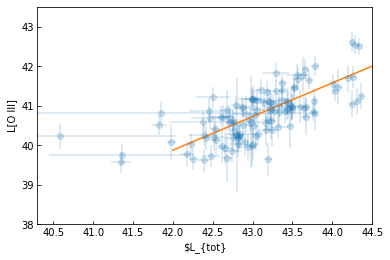

In [217]:
# plot L[O III] vs L_tot
this_L = this_Ldata['LO3_redcorr'].data
this_L_err = 0.5 * (this_Ldata['LO3_redcorr_err_up'].data + this_Ldata['LO3_redcorr_err_low'].data)

if True: # do the linear fitting
    xfit = np.array(L_tot)
    xfit_err = np.array(L_tot_err)

    yfit = this_L
    yfit_err = this_L_err

    ss = (xfit < 1e4) & (xfit > 1e-4) & (yfit > 0) & (yfit < 1e4) & (xfit_err < 2) & (yfit_err < 2)

    p = lts_linefit(xfit[ss], yfit[ss], xfit_err[ss], yfit_err[ss], clip=3, epsy=True, corr=True, frac=None, 
                        pivot=0, plot=False, text=False)
    xlimits = np.linspace(42., 46.5, 100)
    y_res = p.ab[0] + p.ab[1]*xlimits
    plt.errorbar(xfit[ss], yfit[ss], xerr=xfit_err[ss], yerr=yfit_err[ss], ls='None', marker='o', alpha=0.2)
    plt.plot(xlimits, y_res)

    plt.xlabel(r'$L_{tot}$')
    plt.ylabel('L[O III]')

    plt.xlim(40.3, 44.5)
    plt.ylim(38.0, 43.5)

In [328]:
# calculate the radio luminosity
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
c_targets = SkyCoord(ra=targets['ra']*u.degree, dec=targets['dec']*u.degree)

first = Table.read('data/first_14dec17.fits.gz')
first[:3]

c_first = SkyCoord(ra=first['RA'], dec=first['DEC'])

idx, d2d, d3d = c_targets.match_to_catalog_sky(c_first)
matched = d2d < 5*u.arcsec

first_flux = np.zeros(len(targets))
first_flux[matched] = first[idx]['FINT'][matched]

In [329]:
# calculate the radio loudness
LO3data = Table.read('data/LO3-2019-04-29.dat', format="ascii")
Lv_4400 = np.array(Lv_4400)

Lv_5GHz_list = []
Lv_first_list = []
loudness = []
for idx, gal in enumerate(LO3data[:]):
    plateifu = gal['plateifu']
    m = maps.Maps(plateifu)
    LO3 = gal['LO3_redcorr']
    f_22cm = first_flux[idx] * 1e-26  # mJy to erg/s/cm^2/Hz, 22cm ~ 1.363GHz
    f_5GHz = 10**(np.log10(f_22cm) - 0.8*(np.log10(5e9)-np.log10(1.363e9)))
    Lv_22cm = f_22cm /(u.cm**2) * 4*np.pi*(m.d**2).to(u.cm**2) # 22cm luminosity
    Lv_5GHz = f_5GHz /(u.cm**2) * 4*np.pi*(m.d**2).to(u.cm**2)
    #print(Lv_22cm, Lv_5GHz)
    #logL_22cm = np.log10(L_22cm.value+1e-8)
    Lv_5GHz_list.append(Lv_5GHz)
    Lv_first_list.append(np.log10(Lv_22cm * 3e10/22))
    loudness.append(Lv_5GHz / Lv_4400[idx])
    if loudness[-1] > 10:
    #    print(m.ra, m.dec, LO3, Lv_5GHz, Lv_5GHz*5e9, Lv_5GHz / Lv_4400[idx])
        print(Lv_22cm, Lv_5GHz, np.log10(Lv_22cm * 3e10/22))
    #if Lv_22cm > 1:
    #    print(Lv_22cm, Lv_5GHz)
#first_L = np.array(first_L)

if True: #save loudness
    loudness = np.array(loudness)
    np.savetxt('data/loudness.txt', loudness)
    
if True: # save Lv_22cm
    Lv_first = np.array(Lv_first_list)
    np.savetxt('data/Lv_first.txt', Lv_first)

7.092958774131178e+30 2.507541427709128e+30 39.985526009536294
4.663404045242347e+30 1.648632003930388e+30 39.80340161899322
3.347894334696144e+30 1.1835658442652636e+30 39.65947031635411
1.0803052977444669e+30 3.819154142764217e+29 39.16824507974454
2.5632872304231915e+30 9.061872662852529e+29 39.54349584789228
1.0380971470737838e+31 3.6699375890465597e+30 40.15093657140208
5.426835724339623e+30 1.9185245302402425e+30 39.86924524915435


## Morphology with jet

In [60]:
# Plot the Ha, to check the classification of type-I galaxies

import matplotlib.backends.backend_pdf as mpdf

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder
save = True
plot = True
show_detail = True
agn_type = []

if save:
    plt.ioff() #turnoff the inline plot, just save them to file
    pdf = mpdf.PdfPages('results/Hbmap-{}.pdf'.format(today))
    i=0

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
tot_num = len(targets[:])
for i in range(tot_num):
    plateifu = targets['plateifu'][i]
    m = maps.Maps(plateifu)
    fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
    Hb_narrow = fm.line('Hbeta')
    Hb_broad = fm.line('_Hbeta')
    a, b = Hb_narrow[0].shape
    ratio = Hb_broad[0, a//2, b//2] / Hb_narrow[0, a//2, b//2]
    pixels_snr = np.sum((Hb_broad[0] / Hb_broad[1]) > 5)
    pixels_vdisp = np.sum(Hb_broad[3] > 1000)
    
    if show_detail:
        #print("{}: {}, ratio:{}, snr:{}, pixels:{}")
        if (ratio > 0) & (pixels_snr > 5) & (pixels_vdisp > 5):
            print(i, plateifu)
            agn_type.append(1)
            plot = True
        else:
            agn_type.append(2)
            plot = False
    
    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(8, 6))
        plt.suptitle("{}: ratio={:.2f}, snr={:.2f}, pixels={}".format(
                      plateifu, ratio, pixels_snr, pixels_vdisp))
        m.image(ax=ax[0,0], showImage=False, mini=True)
        m.bpt2d(ax=ax[0,1], showImage=False, show_psf=True, mini=True)
        m.line('Ha-6564', plot=True, ax=ax[0,2], showImage=False, redcorr=False, mini=True)
        # fitting map
        im10 = ax[1,0].imshow(Hb_narrow[0], origin='lower')
        ax[1,0].set_title('Hb_narrow', fontsize=10)
        fig.colorbar(im10, ax=ax[1,0], fraction=0.046, pad=0.04)
        im11 = ax[1,1].imshow(Hb_broad[0], origin='lower')
        ax[1,1].set_title('Hb_broad', fontsize=10)
        fig.colorbar(im11, ax=ax[1,1], fraction=0.046, pad=0.04)
        im12 = ax[1,2].imshow(Hb_narrow[0] + Hb_broad[0], origin='lower')
        ax[1,2].set_title('Hb_narrow + Hb_broad', fontsize=10)
        fig.colorbar(im12, ax=ax[1,2], fraction=0.046, pad=0.04)

        plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.2)
        if save:
            pdf.savefig(fig)
        plt.close()
        #utils.processBar(tot_num-1, i)
if save:
    pdf.close()
    %matplotlib inline
    print("Done! Plot into results/Hbmap-{}.pdf".format(today))

#agn_type = np.array(agn_type)

1 7815-6104
12 8341-12704
22 8318-6102
38 8718-12702
40 8725-9102
42 8715-3702
45 8241-6102
71 9183-3703
73 8992-3702
74 9485-12705
75 9487-3702
79 8311-6104
88 9502-12703
94 9048-1902
116 8723-6104
135 9091-3704
143 8614-12703
146 9032-12701
148 8593-12705
150 9090-3701
Done! Plot into results/Hbmap-2019-06-16.pdf


In [55]:
LO3data = Table.read('data/LO3-2019-04-29.dat', format="ascii")
Rdata = Table.read('data/R_fsb(10)-2019-05-03.dat', format='ascii')

LO3 = LO3data['LO3_redcorr']
LO3_err = LO3data['LO3_redcorr_err_up']

R = Rdata['logR_fsb2_orig']
R_err = Rdata['logR_fsb2_orig_err']
is_limit = Rdata['is_limit'].data == 1
R[is_limit] = Rdata['logR_fsb1'].data[is_limit]

#mcmc_fitting = Table.read('data/mcmc.txt', format='ascii')
#is_converge = (mcmc_fitting['is_converge'] >= 1)

#LO3 = LO3[is_converge]
#LO3_err = LO3_err[is_converge]
#R = R[is_converge]
#R_err = R_err[is_converge]

# plot the ENLR shape
NLR_round = []
NLR_twoside = []
NLR_twoside_plateifu = []
NLR_oneside = []
NLR_unresolved = []
all_list = []
all_morphology = []
for i in range(len(LO3data['plateifu'])):
    #if not is_converge[i]:
    #    continue
    shape = None
    plateifu = LO3data['plateifu'][i]
    m = maps.Maps(plateifu)
    O3_i = LO3[i]
    O3_err_i = LO3_err[i]
    R_i = R[i]
    try:
        r1, r2 = m.eshape(useHaEW=True)
    except:
        print("Error when doing {}".format(plateifu))
        continue
    #print(r1, r2)
    if r2 >= 0.3:
        if r1 > r2:
            NLR_oneside.append([O3_i, R_i])
            shape = 'conical'
        else:
            NLR_twoside.append([O3_i, R_i])
            NLR_twoside_plateifu.append(plateifu)
            shape = 'bi-conical'
    elif r1 >= 0.3:
        NLR_oneside.append([O3_i, R_i])
        shape = 'conical'
    else:
        NLR_round.append([O3_i, R_i])
        shape = 'round'
    all_list.append([r1, r2])
    all_morphology.append(shape)

### Plot the results

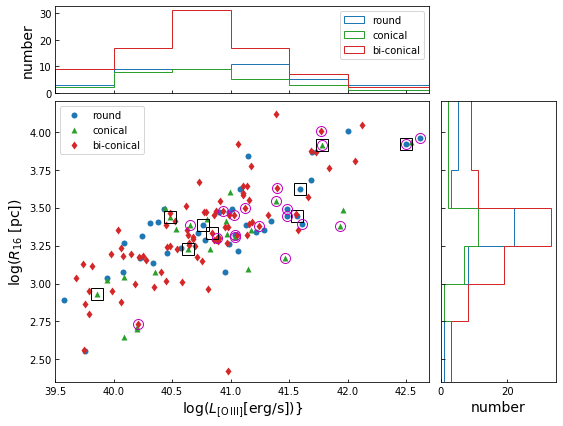

In [61]:
# plot
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()  

set_matplotlib_formats('png')
fig = plt.figure(figsize=(8,6))
fs=14
xbins = [39.5, 40, 40.5, 41, 41.5, 42, 43]
ybins = [2., 2.75, 3. ,3.25, 3.5, 3.75, 4.5]
cols = ['C0', 'C2', 'C3']
agn_type = np.array(agn_type)

if True:
    # plot different shape
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    # start with a rectangular Figure
    ax = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    NLR_round = np.array(NLR_round)
    NLR_twoside = np.array(NLR_twoside)
    NLR_oneside = np.array(NLR_oneside)
    NLR_unresolved = np.array(NLR_unresolved)
    S_round = ax.plot(NLR_round[:,0], NLR_round[:,1], linestyle='None', marker='o', label='round', markeredgecolor='None', markerfacecolor=cols[0])
    S_oneside = ax.plot(NLR_oneside[:,0], NLR_oneside[:,1], linestyle='None', marker='^', label='conical',  markeredgecolor='None', markerfacecolor=cols[1])
    S_twoside = ax.plot(NLR_twoside[:,0], NLR_twoside[:,1], linestyle='None', marker='d', label='bi-conical',  markeredgecolor='None', markerfacecolor=cols[2])
    #ax.plot(NLR_unresolved[:,0], NLR_unresolved[:,1], 'o', label='unresolved', alpha=0.1)
    #plt.legend()
    # plot hist
    binwidth = 0.25

    ax.set_xlim((39.5, 42.7))
    ax.set_ylim((2.35, 4.2))
    
    #axHistx.step((bins1[1:] + bins1[:-1])/2, n1/ntotal)
    #axHistx.step((bins2[1:] + bins2[:-1])/2 + 0.01, n2/ntotal)
    #axHistx.step((bins3[1:] + bins3[:-1])/2 + 0.02, n3/ntotal)
    axHistx.hist(NLR_round[:,0], bins=xbins, histtype='step', color=cols[0], alpha=1, label='round')
    axHistx.hist(NLR_oneside[:,0], bins=xbins, histtype='step', color=cols[1], label='conical', alpha=1)
    axHistx.hist(NLR_twoside[:,0], bins=xbins, histtype='step', color=cols[2], alpha=1, label='bi-conical')
    axHisty.hist(NLR_round[:,1], bins=ybins, orientation='horizontal', histtype='step', color=cols[0], alpha=1)
    axHisty.hist(NLR_oneside[:,1], bins=ybins, orientation='horizontal', histtype='step', color=cols[1])
    axHisty.hist(NLR_twoside[:,1], bins=ybins, orientation='horizontal', histtype='step', color=cols[2], alpha=1)

    axHistx.set_xlim(ax.get_xlim())
    axHisty.set_ylim(ax.get_ylim())

if 1:
    #have_jet = first_L > 38
    have_jet = loudness > 10
    for i, ss in enumerate(have_jet):
        if ss:#and is_converge[i]:
            ax.plot(LO3[i], R[i], color='k', marker='s', label=None, linestyle='None', 
                    markersize=12, markerfacecolor='None', alpha=1)

if 1:
    type1_agn = agn_type == 1
    for i, tp in enumerate(type1_agn):
        if tp:
             ax.plot(LO3[i], R[i], color='m', marker='o', label=None, linestyle='None', 
                    markersize=10, markerfacecolor='None', alpha=1)
            
            
ax.set_xlabel(r"log($L_{\rm [O\,III]}$[erg/s])}", fontsize=fs)
ax.set_ylabel(r"log($R_{16}$ [pc])", fontsize=fs)
ax.legend()
axHistx.set_ylabel('number', fontsize=fs)
axHisty.set_xlabel('number', fontsize=fs)
axHistx.legend()
plt.show()
#plt.legend([S_round, S_twoside, S_oneside, (S_round, Outflow)], ["Attr A", "Attr A+B"])   
fig.savefig('./results/ENLR_morphology.pdf',  bbox_inches='tight')
set_matplotlib_formats('png')

In [62]:
len(NLR_round) / (len(NLR_round) + len(NLR_oneside) + len(NLR_twoside))

0.2631578947368421

In [68]:
from scipy import stats
xbins_new = np.arange(39.5, 43, 0.2)

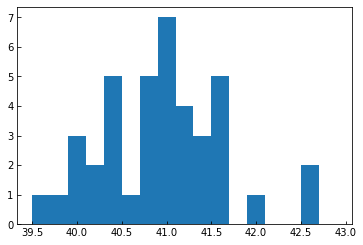

In [69]:
n_round, bins, patches = plt.hist(NLR_round[:,0], bins=xbins_new)

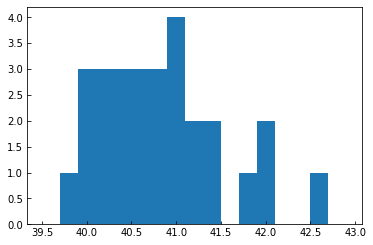

In [70]:
n_oneside, bins, patches = plt.hist(NLR_oneside[:,0], bins=xbins_new)

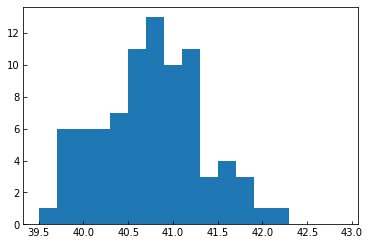

In [71]:
n_twoside, bins, patches = plt.hist(NLR_twoside[:,0], bins=xbins_new)

In [75]:
print(n_round)
print(n_oneside)

[1. 1. 3. 2. 5. 1. 5. 7. 4. 3. 5. 0. 1. 0. 0. 2. 0.]
[0. 1. 3. 3. 3. 3. 3. 4. 2. 2. 0. 1. 2. 0. 0. 1. 0.]


In [74]:
print(stats.ks_2samp(n_round, n_oneside))
print(stats.ks_2samp(n_round, n_twoside))
print(stats.ks_2samp(n_twoside, n_oneside))

Ks_2sampResult(statistic=0.23529411764705888, pvalue=0.6725038222180086)
Ks_2sampResult(statistic=0.4117647058823529, pvalue=0.08130199487731256)
Ks_2sampResult(statistic=0.47058823529411764, pvalue=0.030503048575092007)


In [18]:
len(NLR_round) / (len(NLR_round) + len(NLR_oneside) + len(NLR_twoside))

0.3092105263157895

In [67]:
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

with open('data/morphology-{}.dat'.format(today), 'w') as f:
    f.write("# AGNs_file: data/AGNs-2019-04-26.dat\n")
    f.write("# morphology related data\n")
    f.write("{} {} {} {}\n".format("plateifu", "shape", "agn_type", "radio_loudness"))
    
    tot_num = len(targets[:])
    for i in range(tot_num):
        plateifu = targets['plateifu'][i]
        f.write("{} {} {} {}\n".format(plateifu, all_morphology[i], agn_type[i], loudness[i]))

    print('Done! Write into {}'.format(f.name))

Done! Write into data/morphology-2019-05-03.dat
